In [ ]:
%tensorflow_version 2.x # selecting tensorflow version

!sudo pip install --upgrade pip;
!sudo pip install --upgrade tensorflow;
!sudo pip install efficientnet;

---

## Στοιχεία Ομάδας

Αριθμός Ομάδας F05

  > Καρυπιάδης Ευστράτιος: 03114911
  
  > Σταματελόπουλος Νικόλαος: 03116138

---

## Σύνολο Δεδομένων CIFAR-100

Το σύνολο δεδομένων στο οποίο θα εργαστούμε είναι το [CIFAR-100](https://bit.ly/38CUquZ), το οποίο αποτελείται απο 60.000 έγχρωμες εικόνες διαστάσεων 32x32. Κάθε μία από αυτές ανήκει σε μία γενική(*fine*) και μία ειδική(*coarse*) κατηγορία του συνόλου, πλήθους 100 και 20 αντίστοιχα. Προς ταξινόμηση των δειγμάτων μας θα εκμεταλευτούμε μονάχα τις *fine* κατηγορίες των εικόνων που έχουμε στη διάθεσή μας.

	

### Εισαγωγή συνόλου δεδομένων

In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import datasets, layers, models, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading the entire dataset
(x_train_all, y_train_all), (x_test_all, y_test_all) = tf.keras.datasets.cifar100.load_data(label_mode='fine')

Για τους σκοπούς της άσκησης **δε** θα εκμεταλλευτούμε ολόκληρο το σύνολο δεδομένων, αλλά θα δουλέψουμε σε ένα υποσύνολο αυτού σύμφώνα με τον αύξοντα αριθμό της ομάδας μας, `team_seed`. Στη συνέχεια υλοποιούμε μία σειρά βοηθητικών συναρτήσεων που θα μας βοηθήσουν σε αυτόν το διαχωρισμό:

In [3]:
def select_from_list(from_list, index_list):
  """ Return from_list elemenents according to index contained in index_list. """
  filtered_list= [from_list[i] for i in index_list]
  return(filtered_list)

def get_ds_index(unfiliterd_list, target_list):
  """ Append in filtered_list the index of each element in unfiltered_list if it exists in target_list. """
  index = 0
  filtered_list=[]
  for i_ in unfiliterd_list:
    if i_[0] in target_list:
      filtered_list.append(index)
    index += 1
  return(filtered_list)

def select_classes_number(classes_number=20):
  """ Select unique subset of CIFAR-100 with classes_number of classes. """
  if classes_number == 20:
    return "https://bit.ly/3b3Cewb"
  elif classes_number == 40:
    return "https://bit.ly/3aPo819"
  elif classes_number == 60:
    return "https://bit.ly/2Wbo47K"
  elif classes_number == 80:
    return "https://bit.ly/38NDW3d"
  else:
    return -1

### Διαχωρισμός δεδομένων εκπαίδευσης - ελέγχου

Στο επόμενο κελί επιλέγουμε το πλήθος των κατηγοριών με το οποίο επιθυμούμε να δουλέψουμε:

In [4]:
cifar100_classes_url = select_classes_number(classes_number=80) # default: 20 classes

Δημιουργούμε το μοναδικό dataset της ομάδας μας:

In [5]:
team_seed = 5 # team_seed number

team_classes = pd.read_csv(cifar100_classes_url, sep=',', header=None) # fetch class indexes
CIFAR100_LABELS_LIST = pd.read_csv("https://bit.ly/3cRO3qZ", sep=',', header=None).astype(str).values.tolist()[0] # fetch class names

our_index = team_classes.iloc[team_seed, :].values.tolist() # select team class indices
our_classes = select_from_list(CIFAR100_LABELS_LIST, our_index) # select team class names

train_index = get_ds_index(y_train_all, our_index)
test_index = get_ds_index(y_test_all, our_index)

# Train data and labels
x_train_ds = np.asarray(select_from_list(x_train_all, train_index))
y_train_ds = np.asarray(select_from_list(y_train_all, train_index))

# Test data and labels
x_test_ds = np.asarray(select_from_list(x_test_all, test_index))
y_test_ds = np.asarray(select_from_list(y_test_all, test_index))

Μετά την παραπάνω διαδικασία εμφανίζουμε τα ονόματα των κατηγοριών που αντιστοιχούν στην ομάδα μας:

In [6]:
print(our_classes)

[' aquarium_fish', ' baby', ' bear', ' beaver', ' bee', ' bicycle', ' bottle', ' bowl', ' boy', ' bus', ' camel', ' can', ' castle', ' caterpillar', ' cattle', ' chair', ' clock', ' cloud', ' cockroach', ' crab', ' crocodile', ' cup', ' dinosaur', ' dolphin', ' elephant', ' flatfish', ' forest', ' fox', ' girl', ' hamster', ' kangaroo', ' keyboard', ' lamp', ' lawn_mower', ' leopard', ' lion', ' lizard', ' lobster', ' man', ' maple_tree', ' motorcycle', ' mountain', ' mouse', ' mushroom', ' orange', ' orchid', ' otter', ' palm_tree', ' pickup_truck', ' pine_tree', ' porcupine', ' possum', ' rabbit', ' raccoon', ' ray', ' road', ' rocket', ' rose', ' sea', ' seal', ' shark', ' skunk', ' skyscraper', ' snail', ' snake', ' squirrel', ' streetcar', ' sunflower', ' table', ' tank', ' television', ' tractor', ' train', ' trout', ' tulip', ' turtle', ' wardrobe', ' whale', ' wolf', ' worm']


### Επισκόπηση δεδομένων και κανονικοποίηση

Τέλος, για καλύτερη εποπτεία του συνόλου δεδομένων μας θα εξάγουμε ορισμένες χρήσιμες πληροφορίες για αυτό, ενώ παράλληλα θα κανονικοποιήσουμε τις τιμές αναπαράστασης των εικόνων:

In [7]:
data_size, img_rows, img_cols, img_channels = x_train_ds.shape # get train dataset dimensions

# Set validation set percentage
validation_percentage = 0.15
val_size = round(validation_percentage * data_size)

# Reserve val_size samples for validation and normalize all values
x_val = x_train_ds[-val_size:]/255
y_val = y_train_ds[-val_size:]
x_train = x_train_ds[:-val_size]/255
y_train = y_train_ds[:-val_size]
x_test = x_test_ds/255
y_test = y_test_ds

# Summarize loaded dataset
print('Train:       X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Validation:  X=%s, y=%s' % (x_val.shape, y_val.shape))
print('Test:        X=%s, y=%s' % (x_test.shape, y_test.shape))

Train:       X=(34000, 32, 32, 3), y=(34000, 1)
Validation:  X=(6000, 32, 32, 3), y=(6000, 1)
Test:        X=(8000, 32, 32, 3), y=(8000, 1)


---

## Συναρτήσεις Προετοιμασίας Δεδομένων και Οπτικοποίησης Απόδοσης

Στη συνέχεια θα υλοποιήσουμε απαραίτητες συναρτήσεις προετοιμασίας των δεδομένων για εκπαίδευση, καθώς και οπτικοποίσης της τελικής απόδοσης των μοντέλων που πρόκειται να δοκιμάσουμε.

### Συναρτήσεις εκπαίδευσης

Αρχικά θα υλοποιήσουμε την `_input_fn`, η οποία αποτελεί ένα *pipeline* που θα προετοιμάσει τα δεδομένα μας για την εκπαίδευση. Πιο συγκεκριμένα, χρησιμοποιούμε τις μεθόδους `shuffle`, `repeat` και `batch` της [tf.data.Dataset](https://bit.ly/2vk7EPr), ώστε να δημιουργήσουμε υποσύνολα 64 δειγμάτων, τα οποία ελήφθησαν τυχαίως από το ολικό μας σύνολο. Παρατηρούμε ότι η μέθοδος `repeat` είναι απαραίτητη για να αντιμετωπίσουμε τυχόν σφάλμα που θα προκύψει, εάν η μέθοδος `batch` επιχειρήσει να δημιουργήσει εκ νέου υποσύνολο, αφού έχει ομαδοποιήσει όλα τα διαθέσιμα δείγματα του συνόλου. 

Σημειώνουμε ότι η συνάρτηση επιστρέφει υποσύνολα δεδομένων `PrefetchDataset Objects`, μορφή η οποία επιταχύνει τη διαδικασία εκπαίδευσης, καθώς επιτρέπει το διάβασμα του επόμενου batch δεδομένων, ενώ παράλληλα εκπαιδεύεται το παρόν.

In [8]:
BATCH_SIZE = 64
AUTOTUNE = tf.data.experimental.AUTOTUNE

def _input_fn(x, y, BATCH_SIZE):
  """ Returns shuffled and batched tensors in the form of PrefetchDataset objects. """
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.shuffle(buffer_size=data_size)
  ds = ds.repeat() # repeat indefinately
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

# PrefetchDataset objects
train_ds =_input_fn(x_train, y_train, BATCH_SIZE)
validation_ds =_input_fn(x_val, y_val, BATCH_SIZE)
test_ds =_input_fn(x_test, y_test, BATCH_SIZE)

Στη συνέχεια υλοποιούμε τη συνάρτηση `train_model`. Σημειώνουμε ότι με την παράμετρο `steps_per_epoch` μπορούμε να επιλέξουμε το πλήθος των *batches* στο οποίο επιθυμούμε να εκπαιδευτεί το μοντέλο μας πριν περάσει στην επόμενη εποχή.

In [9]:
def train_model(model, epochs):
  """ Training function. """
  history = model.fit(train_ds, epochs=epochs, steps_per_epoch=x_train.shape[0]//BATCH_SIZE, validation_data=validation_ds, validation_steps=x_val.shape[0]//BATCH_SIZE)
  return(history)

### Γραφικές παραστάσεις εκπαίδευσης και απόδοση στο σύνολο ελέγχου

Τέλος, υλοποιούμε συναρτήσεις οπτικοποίησης της απόδοσης της εκπαίδευσης προς εξαγωγή χρήσιμων πληροφοριών και μελέτη των αποτελεσμάτων που θα προκύψουν από τη δοκιμή των μοντέλων μας.

In [43]:
def summarize_diagnostics(history):
	""" Plot diagnostic learning curves. """
	plt.figure(figsize=(10, 6))
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='Train')
	plt.plot(history.history['val_accuracy'], color='orange', label='Validation')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()
 
def model_evaluation(model, evaluation_steps):
	""" Print test set and evaluation metrics. """
	print('\nTest set evaluation metrics')
	loss, accuracy = model.evaluate(test_ds, steps=x_test.shape[0]//BATCH_SIZE)
	print("loss: {:.2f}".format(loss))
	print("accuracy: {:.2f}".format(accuracy))

def model_report(model, history, evaluation_steps=10):
	plt = summarize_diagnostics(history)
	plt.show()
	model_evaluation(model, evaluation_steps)
 
def summarize_all_diagnostics(m1, m2, m3):
	plt.figure(figsize=(18, 6))
	plt.suptitle('Classification Accuracy')
	plt.subplot(121)
	plt.title('Train')
	plt.plot(m1['accuracy'], color='red', label='Softmax')
	plt.plot(m2['accuracy'], color='blue', label='MLP')
	plt.plot(m3['accuracy'], color='green', label='LeNet')
	# plt.plot(m4['accuracy'], color='orange', label='CNN1')
	# plt.plot(m5['accuracy'], color='magenta', label='CNN2')
	plt.legend(loc='lower right')
	plt.grid()
	plt.subplot(122)
	plt.title('Validation')
	plt.plot(m1['val_accuracy'], color='red', label='Softmax')
	plt.plot(m2['val_accuracy'], color='blue', label='MLP')
	plt.plot(m3['val_accuracy'], color='green', label='LeNet')
	# plt.plot(m4['val_accuracy'], color='orange', label='CNN1')
	# plt.plot(m5['val_accuracy'], color='magenta', label='CNN2')
	plt.legend(loc='lower right')
	plt.grid()
	plt.show()

---

## Ερώτημα 1: Μοντέλα Δικτύων

In [11]:
import json # for saving training history

Στη συνέχεια καλούμαστε να υλοποιήσουμε 5 διαφορετικές αρχιτεκτονικές συνελικτικών δικτύων. Για κάθε μία από αυτές θα πρέπει να επιλέξουμε δύο βέλτιστους συνδυασμούς optimizer, loss function, metrics και epoch.

- Σχετικά με τους [optimizers](https://keras.io/api/optimizers/) δοκιμάσαμε σε όλες τις αρχιτεκτονικές τους [Adam](https://keras.io/api/optimizers/adam/), [Nadam](https://keras.io/api/optimizers/Nadam/), [Adamax](https://keras.io/api/optimizers/adamax/), [Adagrad](https://keras.io/api/optimizers/adagrad/), [Adadelta](https://keras.io/api/optimizers/adadelta/) και [Stochastic Gradient Descent](https://keras.io/api/optimizers/sgd/). Επιλέξαμε δύο από αυτούς σε κάθε δίκτυο, ανάλογα με την απόδοσή τους. Αξίζει να σημειώσουμε ότι σε κάθε optimizer, πειραματιστήκαμε και με το ρυθμό μάθησης, για να αποφανθούμε για την επίδοσή του.

- Μελετώντας το API του Keras, παρατηρούμε ότι η μοναδική [loss function](https://keras.io/api/losses/) που εξυπηρετεί την επίλυση του προβλήματός μας είναι η [Categorical Cross Entropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class). Καταλήγουμε σε αυτήν την επιλογή, αγνοώντας αφενός τα regression losses, καθώς δεν εφάπτονται της ταξινόμησης εικόνων που επιχειρούμε και αφετέρου τις συναρτήσεις Kullback-Leibler Divergence και Hinge. Σχετικά με τις δύο τελευταίες, παρατηρούμε ότι μέσα από πειραματισμούς μας δε φαίνεται να συγκλίνουν σε ελάχιστη τιμή, ενώ παράλληλα δίνουν χαμηλές τιμές απόδοσης στα metrics που δοκιμάσαμε. Επίσης σημειώνουμε ότι οι συγκεκριμένες συναρτήσεις συνηθίζεται να χρησιμοποιούνται σε διαφορετικού τύπου εφαρμογές, όπως για παράδειγμα στους Autoencoders.

- Βασική μας [metric](https://keras.io/api/metrics/) συνάρτηση είναι η [ακρίβεια ταξινόμησης](https://keras.io/api/metrics/accuracy_metrics/#accuracy-class), πάνω στην οποία θα στηριχτούμε προκειμένου να αποφανθούμε για την απόδοση των δικτύων μας.

- Τέλος, σημειώνουμε ότι κατά τη διαδικασία δοκιμών των παραπάνω παραμέτρων, εκπαιδεύσαμε πειραματικά κάθε δίκτυο για διάρκεια 10 εποχών. Σύμφωνα με τα αποτελέσματα που συλλέξαμε, επιλέξαμε για την εκάστοτε αρχιτεκτονική τους 2 καλύτερους συνδυασμούς, τους οποίους χρησιμοποιήσαμε για την ολοκληρωμένη εκπαίδευση, διάρκειας 50 εποχών, των τελικών 10 δικτύων μας.

### Softmax

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Παρατηρώντας το διάγραμμα απόδοσης που ακολουθεί, οι 50 `epochs` είναι αρκετές για την εκπαίδευση του μοντέλου, δεδομένου ότι δεν παρουσιάζεται τάση ανόδου για την απόδοση του δικτύου στα δεδομένα επαλήθευσης.

In [ ]:
def init_softmax_adam(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAM = init_softmax_adam(summary=True)

# Train for 50 epochs
SOFTMAX_MODEL_ADAM_history = train_model(SOFTMAX_MODEL_ADAM, 50)

# Dump training history
history_dict = SOFTMAX_MODEL_ADAM_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAM.json', 'w'))

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_55 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_101 (Dense)            (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
531/531 [==============================] - 2s 4ms/step - loss: 4.1454 - accuracy: 0.0654 - val_loss: 3.9210 - val_accuracy: 0.1006
Epoch 2/50
531/531 [==============================] - 2s 4ms/step - loss: 3.8296 - accuracy: 0.1208 - val_loss: 3.7833 - val_accuracy: 0.1354
Epoch 3/50
531/531 [==============================] - 2s 4ms/step - loss: 3.7195 - accuracy: 0.1429 - val_loss: 3.7322 - val_accuracy: 0.1425
Epoch 4/50
531/531 [==============================] - 2s 4ms/step - loss: 3.6513 - 

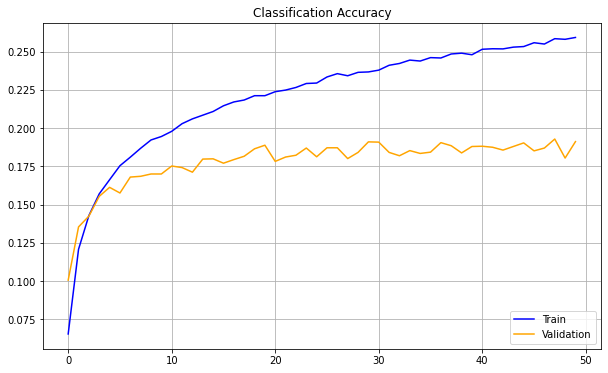

In [ ]:
summarize_diagnostics(SOFTMAX_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε και εδώ τις 50 `epochs` εκπαίδευσης.

In [ ]:
def init_softmax_adagrad(summary):
  
  model = models.Sequential()
  
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
SOFTMAX_MODEL_ADAGRAD = init_softmax_adagrad(summary=True)

# Train for 50 epochs
SOFTMAX_MODEL_ADAGRAD_history = train_model(SOFTMAX_MODEL_ADAGRAD, 50)

# Dump training history
history_dict = SOFTMAX_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('SOFTMAX_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_53 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_99 (Dense)             (None, 200)               614600    
Total params: 614,600
Trainable params: 614,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
531/531 [==============================] - 2s 4ms/step - loss: 4.0617 - accuracy: 0.0781 - val_loss: 3.8657 - val_accuracy: 0.0998
Epoch 2/50
531/531 [==============================] - 2s 4ms/step - loss: 3.7354 - accuracy: 0.1342 - val_loss: 3.7398 - val_accuracy: 0.1349
Epoch 3/50
531/531 [==============================] - 2s 4ms/step - loss: 3.6370 - accuracy: 0.1549 - val_loss: 3.6621 - val_accuracy: 0.1484
Epoch 4/50
531/531 [==============================] - 2s 4ms/step - loss: 3.5737 - 

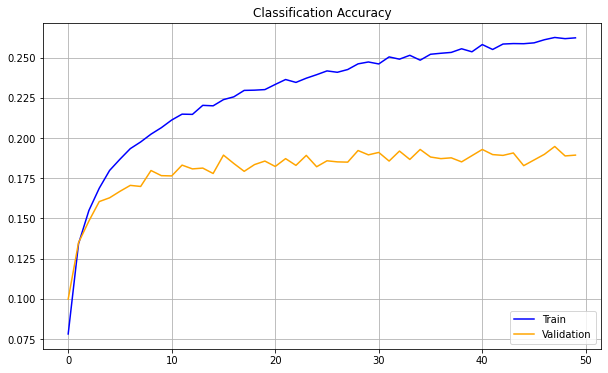

In [ ]:
summarize_diagnostics(SOFTMAX_MODEL_ADAGRAD_history)

### MLP

Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Εδώ επιλέγουμε 75 `epochs` εκπαίδευσης παρατηρώντας την ανοδική τάσης της ακρίβειας του δικτύου στα δεδομένα επαλήθευσης που κυριαρχούσε στις 50 εποχές.

In [ ]:
def init_mlp_adam(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_ADAM = init_mlp_adam(summary=True)

# Train for 50 epochs
MLP_MODEL_ADAM_history = train_model(MLP_MODEL_ADAM, 75)

# Dump training history
history_dict = MLP_MODEL_ADAM_history.history
json.dump(history_dict, open('MLP_MODEL_ADAM.json', 'w'))

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_68 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_126 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dense_127 (Dense)            (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
531/531 [==============================] - 2s 4ms/step - loss: 4.0920 - accuracy: 0.0781 - val_loss: 3.8594 - val_accuracy: 0.1077
Epoch 2/75
531/531 [==============================] - 2s 4ms/step - loss: 3.7321 - accuracy: 0.1302 - val_loss: 3.6847 - val_accuracy: 0.1467
Epoch 3/75
531/531 [==============================] - 2s 4ms/step - loss: 3.5925 - accura

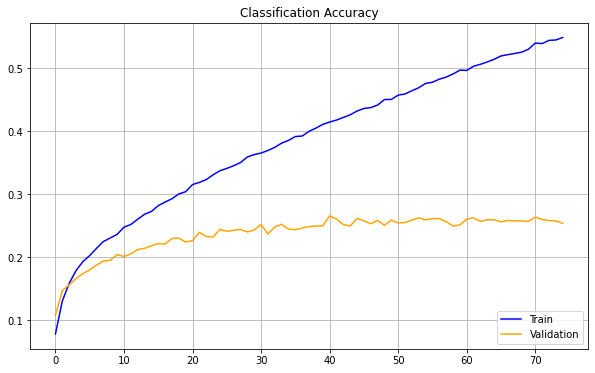

In [ ]:
summarize_diagnostics(MLP_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `SGD` optimizer με `lr=0.01`. Σε αυτήν την περίπτωση θα αυξήσουμε τις `epochs` εκπαίδευσης στις 100, λαμβάνοντας υπόψιν την ανοδική τάση της καμπύλη ακριβείας που αντιστοιχεί στην επαλήθευση του δικτύου.

In [ ]:
def init_mlp_sgd(summary):
  
  model = models.Sequential()
 
  model.add(layers.Flatten(input_shape=(32, 32, 3)))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.SGD(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

In [ ]:
# Initialize model
MLP_MODEL_SGD = init_mlp_sgd(summary=True)

# Train for 50 epochs
MLP_MODEL_SGD_history = train_model(MLP_MODEL_SGD, 100)

# Dump training history
history_dict = MLP_MODEL_SGD_history.history
json.dump(history_dict, open('MLP_MODEL_SGD.json', 'w'))

Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_70 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_130 (Dense)            (None, 512)               1573376   
_________________________________________________________________
dense_131 (Dense)            (None, 200)               102600    
Total params: 1,675,976
Trainable params: 1,675,976
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
531/531 [==============================] - 2s 4ms/step - loss: 4.2869 - accuracy: 0.0526 - val_loss: 4.0094 - val_accuracy: 0.0815
Epoch 2/100
531/531 [==============================] - 2s 4ms/step - loss: 3.8944 - accuracy: 0.0978 - val_loss: 3.8121 - val_accuracy: 0.1148
Epoch 3/100
531/531 [==============================] - 2s 4ms/step - loss: 3.7500 - acc

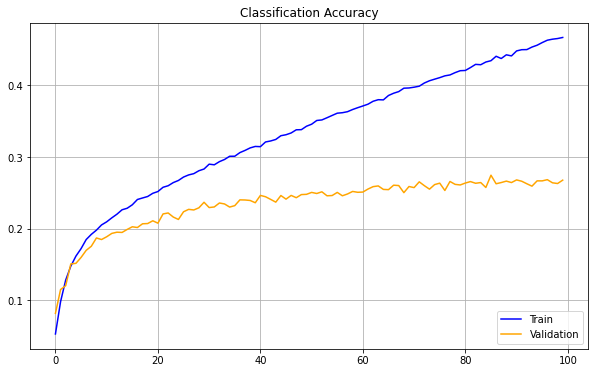

In [ ]:
summarize_diagnostics(MLP_MODEL_SGD_history)

### LeNet

In [ ]:
def init_lenet_(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

### CNN1

In [ ]:
def init_cnn1_(summary):
  
  model = models.Sequential()
 
  model.add(layers.Conv2D(16, (5, 5), activation='relu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  model.add(layers.Flatten())
  model.add(layers.Dense(200, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary:
    model.summary()
  return model

### CNN2

Η αρχιτεκτονική του δικτύου μας είναι επηρεασμένη από εκείνη του VGG16. Το πρώτο μοντέλο που θα εκπαιδεύσουμε εκμεταλλεύεται optimizer `Adam` με `lr=0.0001`. Παρατηρούμε ότι οι 50 `epochs` εκπαίδευσης είναι αρκετές για το μοντέλο μας.

In [ ]:
def init_CNN2_adam(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAM = init_CNN2_adam(summary=True)

# Train for 50 epochs
CNN2_MODEL_ADAM_history = train_model(CNN2_MODEL_ADAM, 50)

# Dump training history
history_dict = CNN2_MODEL_ADAM_history.history
json.dump(history_dict, open('CNN2_MODEL_ADAM.json', 'w'))

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_215 (Conv2D)          (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_109 (MaxPoolin (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_217 (Conv2D)          (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_218 (Conv2D)          (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_110 (MaxPoolin (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 6, 6, 512)       

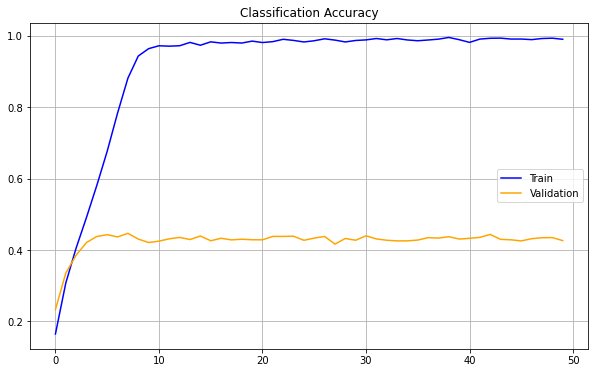

In [ ]:
summarize_diagnostics(CNN2_MODEL_ADAM_history)

Το δεύτερο μοντέλο μας έχει `Adagrad` optimizer με `lr=0.01`. Διατηρούμε σταθερή τη διάρκεια εκπαίδευσης στις 50 `epochs`.

In [ ]:
def init_CNN2_adagrad(summary):
  
  model = models.Sequential()
  
  model.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same', input_shape=(32, 32, 3)))
  model.add(layers.Conv2D(128, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(512, (3, 3), activation='elu', padding='same'))
  model.add(layers.Conv2D(512, (3, 3), activation='elu'))
  model.add(layers.MaxPooling2D((2, 2)))
 
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation='elu'))
  model.add(layers.Dense(100, activation='softmax'))
  
  model.compile(optimizer=tf.optimizers.Adagrad(lr=0.01), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  
  if summary: 
    model.summary()
  return model

In [ ]:
# Initialize model
CNN2_MODEL_ADAGRAD = init_CNN2_adagrad(summary=True)

# Train for 50 epochs
CNN2_MODEL_ADAGRAD_history = train_model(CNN2_MODEL_ADAGRAD, 50)

# Dump training history
history_dict = CNN2_MODEL_ADAGRAD_history.history
json.dump(history_dict, open('CNN2_MODEL_ADAGRAD.json', 'w'))

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_221 (Conv2D)          (None, 32, 32, 128)       3584      
_________________________________________________________________
conv2d_222 (Conv2D)          (None, 30, 30, 128)       147584    
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 15, 15, 128)       0         
_________________________________________________________________
conv2d_223 (Conv2D)          (None, 15, 15, 256)       295168    
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 13, 13, 256)       590080    
_________________________________________________________________
max_pooling2d_113 (MaxPoolin (None, 6, 6, 256)         0         
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 6, 6, 512)       

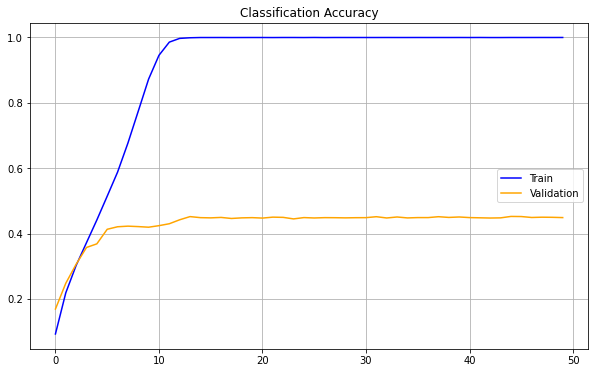

In [ ]:
summarize_diagnostics(CNN2_MODEL_ADAGRAD_history)

### Αξιολόγηση Μοντέλων

In [46]:
# Reload best history according to accuracy-loss
m1 = json.load(open('SOFTMAX_MODEL_ADAM.json', 'r'))
m2 = json.load(open('MLP_MODEL_ADAM.json', 'r'))
# m3 = json.load(open('', 'r'))
# m4 = json.load(open('', 'r'))
m5 = json.load(open('CNN2_MODEL_ADAGRAD.json', 'r'))

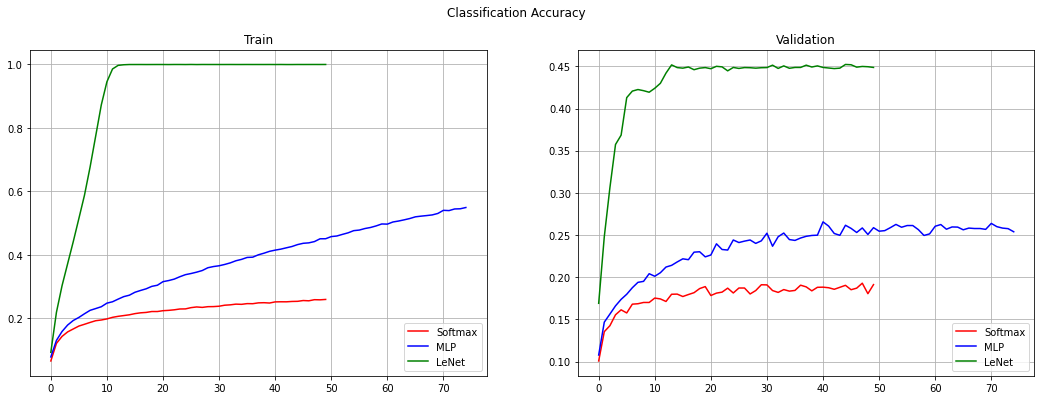

In [47]:
summarize_all_diagnostics(m1, m2, m5)

---

## Ερώτημα 2: Αντιμετώπιση Υπερεκπαίδευσης

Θα εξετάσουμε τη μέθοδο εμπλουτισμού του συνόλου δεδομέων μας με μετασχηματισμένες εικόνες εισόδου, προκειμένου να βελτιώσουμε τη συνολική απόδοση των δικτύων μας, αλλά και για να αντιμετωπίσουμε το πρόβλημα της υπερ-εκπαίδευσης στα δεδομένα εκπαίδευσης που παρατηρούμε στα παραπάνω διαγράμματα.

Για το σκοπό αυτό θα χρησιμοποιήσουμε τον [ImageDataGenerator](https://bit.ly/33B1reJ), από τον οποίο θα επιλέξουμε τους μετασχηματισμούς `rotation_range`, `width_shift_range`, `height_shift_range` και `horizontal_flip`.

In [ ]:
datagen = ImageDataGenerator(rotation_range=0, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

datagen.fit(x_train)

Εξετάζουμε αρχικά το δίκτυο με αλγόριθμο ενεργοποίησης *Adam*:

In [ ]:
ADAM_MODEL_AUG = init_adam_model(summary = True)

ADAM_MODEL_AUG.fit(datagen.flow(x_train, y_train, batch_size=64), steps_per_epoch=x_train.shape[0]//64, epochs=100, validation_data=(x_val, y_val))

### Softmax

### MLP

### LeNet

### CNN1

### CNN2

---

## Ερώτημα 3: Transfer Learning